In [1]:
import praw
from datetime import datetime, timedelta
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
reddit = praw.Reddit(
    client_id='c1zPstvJWTomkEcLRHoYtw',
    client_secret='8OngFIaoK-wkB7TUPJ1M_YLavDEeiw',
    user_agent='ThesisApp/0.1 by /u/Relative-Chocolate-8'
)

Version 7.7.1 of praw is outdated. Version 7.8.0 was released 22 hours ago.


In [18]:
sid = SentimentIntensityAnalyzer()

In [123]:
# Define your queries and parameters
queries = ["environmental sustainability", "economic sustainability", "human sustainability", "social sustainability"]
sort_by = "top"  # Can be 'relevance', 'hot', 'top', 'new', etc.
limit = 1000  # Limit the number of posts to fetch
start_timestamp = datetime(2019, 1, 1).timestamp()  # Start of 2019
end_timestamp = datetime(2019, 12, 31).timestamp()  # End of 2019

# Initialize lists to store posts and comments data
all_posts = []
comments_2019 = []

# Loop through each query and fetch posts
for query in queries:
    posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

    # Collect the posts, including author information and sentiment
    for submission in posts_best:
        post_date = datetime.fromtimestamp(submission.created_utc)
        
        # Append post data for the main table
        all_posts.append({
            'title': submission.title,
            'score': submission.score,
            'id': submission.id,
            'url': submission.url,
            'num_comments': submission.num_comments,
            'created': post_date,
            'subreddit': submission.subreddit.display_name,
            'author': str(submission.author),
            'selftext': submission.selftext
        })

        # Check if the post is from 2019
        if start_timestamp <= submission.created_utc <= end_timestamp:
            # Analyze sentiment of the post
            post_text = submission.title + " " + submission.selftext
            post_sentiment = sid.polarity_scores(post_text)['compound']
            
            # Fetch comments for 2019 posts
            submission.comments.replace_more(limit=0)  # Replace "MoreComments" objects
            for comment in submission.comments.list():
                comment_text = comment.body
                comment_sentiment = sid.polarity_scores(comment_text)['compound']
                
                # Append comment data to the 2019 comments table
                comments_2019.append({
                    'post_id': submission.id,
                    'comment_id': comment.id,
                    'comment_text': comment_text,
                    'comment_author': str(comment.author),
                    'comment_sentiment': comment_sentiment,
                    'comment_created': datetime.fromtimestamp(comment.created_utc)
                })

# Convert posts to DataFrame
df_all = pd.DataFrame(all_posts)

# Convert comments from 2019 to DataFrame
df_comments_2019 = pd.DataFrame(comments_2019)

# Check if DataFrames are empty
if df_all.empty:
    print("No posts found.")
else:
    print(f"Total posts found: {len(df_all)}")

if df_comments_2019.empty:
    print("No comments from 2019 found.")
else:
    print(f"Total comments from 2019: {len(df_comments_2019)}")


Total posts found: 927
Total comments from 2019: 20673


In [124]:
def clean_post_text(text):
    # 1. Lowercase the text
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    
    # 4. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 5. Tokenize the text
    words = word_tokenize(text)
    
    # 6. Remove stop words and lemmatize words
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # 7. Join the cleaned words back into a single string
    return ' '.join(cleaned_text)

# Example usage to clean Reddit posts
df_all['Cleaned Post Text'] = df_all['selftext'].apply(clean_post_text)


In [125]:

# Function to analyze sentiment of a post
def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

# Apply sentiment analysis to each cleaned post
df_all['Sentiment Scores'] = df_all['Cleaned Post Text'].apply(analyze_sentiment)

# Extract compound score and classify the sentiment as positive, negative, or neutral
df_all['Compound'] = df_all['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_all['Sentiment'] = df_all['Compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))


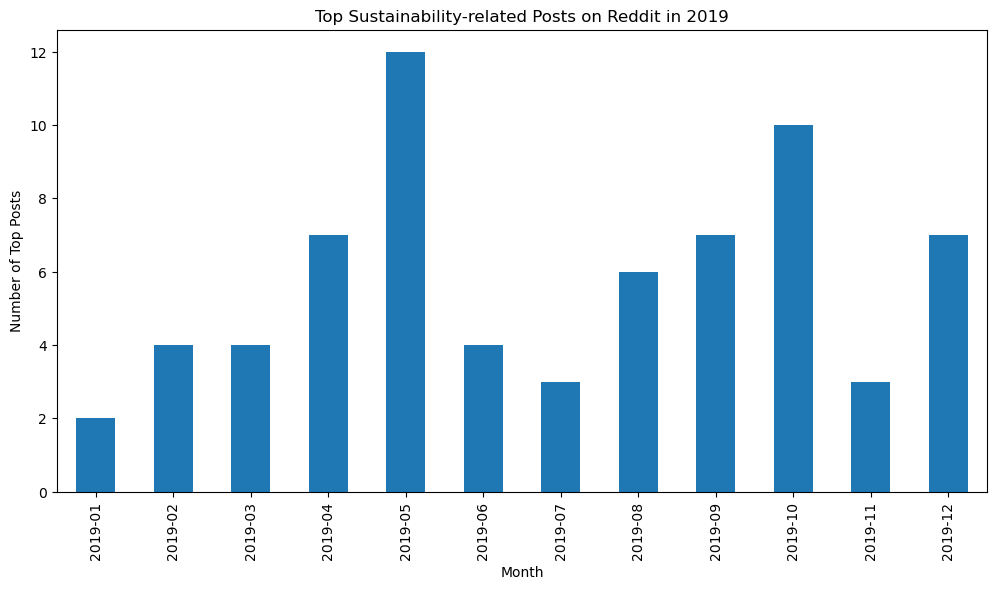

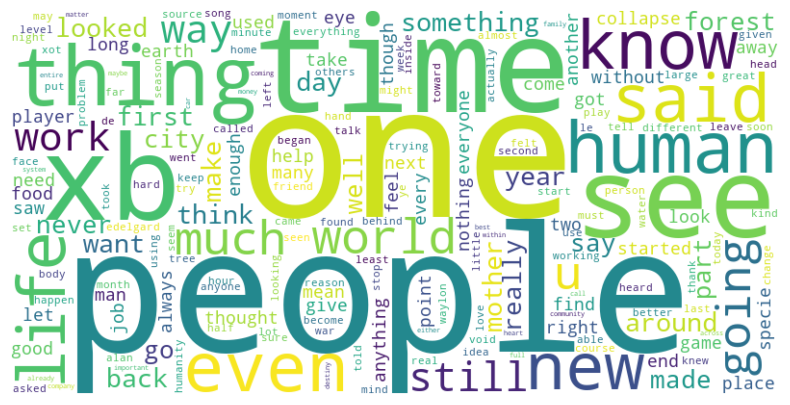

Top Authors in 2019:
author
ScienceModerator    5
giftedearth         4
captainflash89      2
Ucumu               2
Logiman43           2
Bentoki             2
Cheezcayk           2
Odd_directions      2
throwsawauy76       2
realestnwah         1
Name: count, dtype: int64
subreddit
nosleep             7
HFY                 6
science             6
AmItheAsshole       3
unpopularopinion    3
space               3
runescape           2
fireemblem          2
DarkFuturology      2
collapse            2
Name: count, dtype: int64
count    927.000000
mean       0.421939
std        0.785086
min       -0.999900
25%        0.000000
50%        0.974200
75%        0.997800
max        1.000000
Name: Compound, dtype: float64


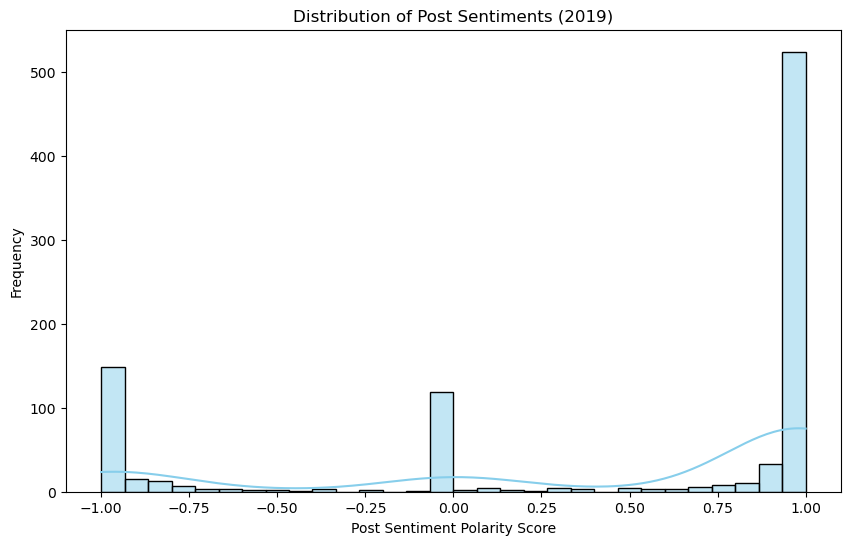

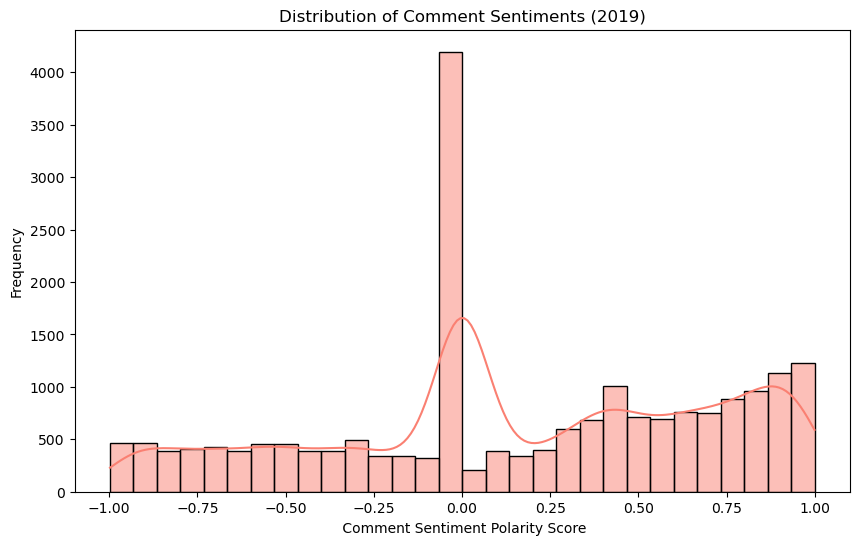

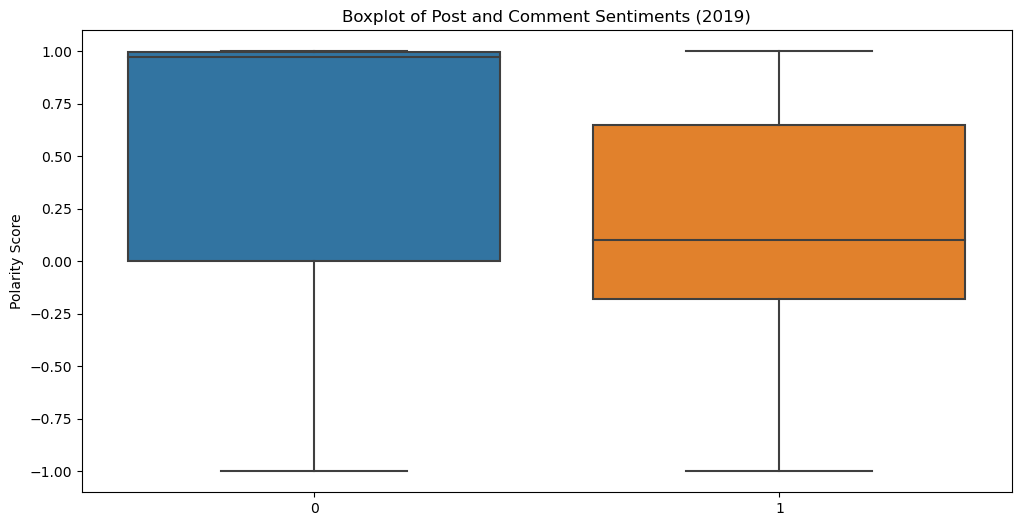

In [26]:
# Analyze the data
df_all['month'] = df_all['created'].dt.to_period('M')

#Filter for 2019
df_2019 = df_all[(df_all['created'].dt.year == 2019)]
top_posts_per_month = df_2019.groupby('month').size()

# Plotting the number of top posts over time
top_posts_per_month.plot(kind='bar', figsize=(12, 6))
plt.title("Top Sustainability-related Posts on Reddit in 2019")
plt.xlabel("Month")
plt.ylabel("Number of Top Posts")
plt.show()

# Create the word cloud
# Concatenate the 'body' and 'text' columns into a single string
combined_text = ' '.join(df_2019['Cleaned Post Text'] + ' ' + df_2019['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()

# Group by author and count the number of posts per author
author_distribution = df_2019['author'].value_counts()

# Print the top authors
print("Top Authors in 2019:")
print(author_distribution.head(10))

sub_distribution = df_2019['subreddit'].value_counts()

print(sub_distribution.head(10))

print(df_all['Compound'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_all['Compound'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Sentiments (2019)')
plt.xlabel('Post Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_comments_2019['comment_sentiment'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Comment Sentiments (2019)')
plt.xlabel(' Comment Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=[df_all['Compound'], df_comments_2019['comment_sentiment']])
plt.title('Boxplot of Post and Comment Sentiments (2019)')
plt.ylabel('Polarity Score')
plt.show()


/var/folders/cv/8p3v6nnj09vgrlq0h88m03wh0000gn/T/ipykernel_4782/1682202429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['text_combined'] = df_2019['title'] + ' ' + df_2019['Cleaned Post Text']


Topic 0:
edelgard people song thing like life know time human year
Topic 1:
xb like time people forest mother day said collapse looked
Topic 2:
year world new season want people like crop change time
Topic 3:
human like specie earth life player day want play team
Topic 4:
ambassador vale ven time specie image humanity aggression like dhuzi


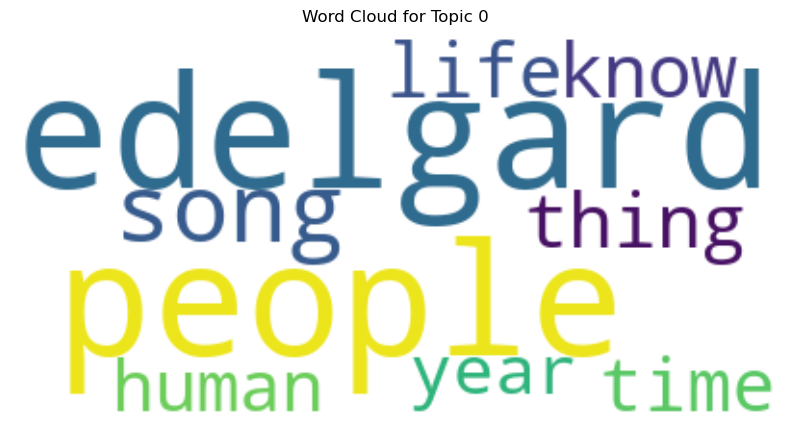

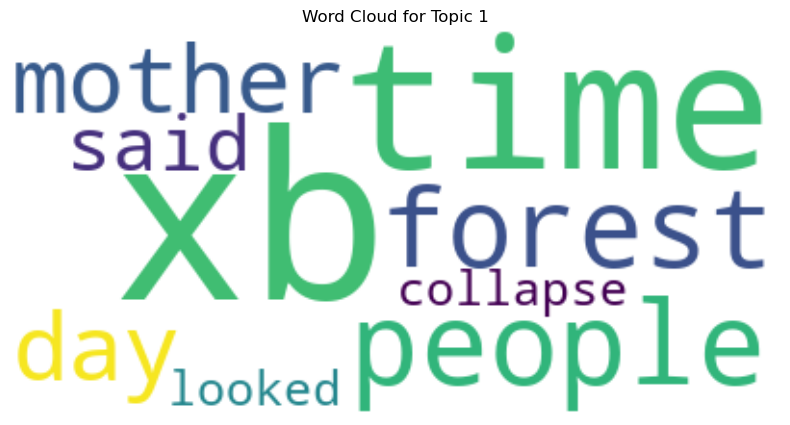

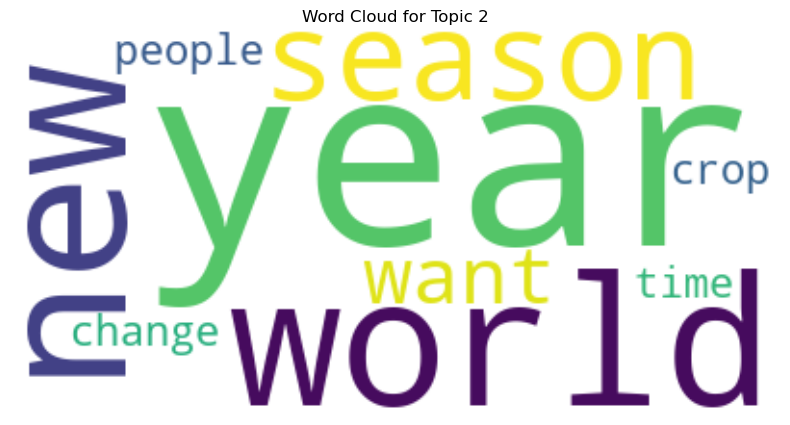

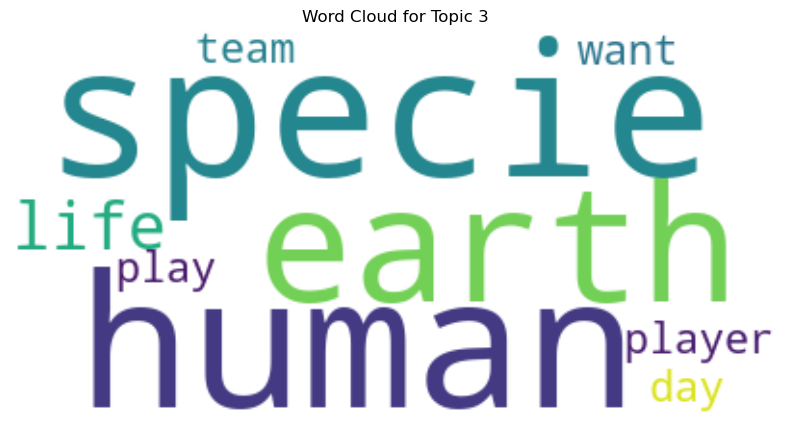

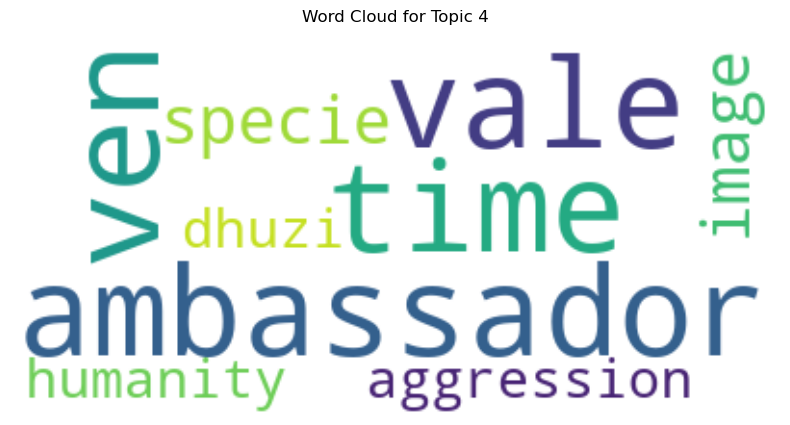

In [28]:
# Combining title and cleaned text for better context
df_2019['text_combined'] = df_2019['title'] + ' ' + df_2019['Cleaned Post Text']

# Step 2: Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectorized = vectorizer.fit_transform(df_2019['text_combined'])

# Step 3: Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_vectorized)

# Step 4: Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Step 5: Create word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color='white').generate(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Improved Preprocessing
vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english', ngram_range=(1, 3))
text_vectorized = vectorizer.fit_transform(df_2019['title'])

# Step 2: Applying LDA with Hyperparameter Tuning
lda = LatentDirichletAllocation(n_components=6, max_iter=30, random_state=42)
lda.fit(text_vectorized)

no_top_words = 6
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
perspective mental mental health health working people
Topic 1:
crops killed ll safe series years
Topic 2:
future science discussion discussion series discuss science discussion series
Topic 3:
human years life aita got environmental
Topic 4:
people oc pretty oc pretty little pretty pretty little deathworlders
Topic 5:
year environmental years people working series


In [50]:
start_timestamp = datetime(2020, 1, 1).timestamp()  
end_timestamp = datetime(2020, 12, 31).timestamp() 

# Initialize lists to store posts and comments data
all_posts = []
comments_2020 = []

# Loop through each query and fetch posts
for query in queries:
    posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

    # Collect the posts, including author information and sentiment
    for submission in posts_best:
        post_date = datetime.fromtimestamp(submission.created_utc)
        
        # Append post data for the main table
        all_posts.append({
            'title': submission.title,
            'score': submission.score,
            'id': submission.id,
            'url': submission.url,
            'num_comments': submission.num_comments,
            'created': post_date,
            'subreddit': submission.subreddit.display_name,
            'author': str(submission.author),
            'selftext': submission.selftext
        })

       
        if start_timestamp <= submission.created_utc <= end_timestamp:
            # Analyze sentiment of the post
            post_text = submission.title + " " + submission.selftext
            post_sentiment = sid.polarity_scores(post_text)['compound']
            
           
            submission.comments.replace_more(limit=0)  # Replace "MoreComments" objects
            for comment in submission.comments.list():
                comment_text = comment.body
                comment_sentiment = sid.polarity_scores(comment_text)['compound']
                
                # Append comment data to the 2019 comments table
                comments_2020.append({
                    'post_id': submission.id,
                    'comment_id': comment.id,
                    'comment_text': comment_text,
                    'comment_author': str(comment.author),
                    'comment_sentiment': comment_sentiment,
                    'comment_created': datetime.fromtimestamp(comment.created_utc)
                })

# Convert posts to DataFrame
df_all = pd.DataFrame(all_posts)

# Convert comments from 2019 to DataFrame
df_comments_2020 = pd.DataFrame(comments_2020)

# Check if DataFrames are empty
if df_all.empty:
    print("No posts found.")
else:
    print(f"Total posts found: {len(df_all)}")

if df_comments_2020.empty:
    print("No comments from 2020 found.")
else:
    print(f"Total comments from 2020: {len(df_comments_2020)}")

Total posts found: 927
Total comments from 2020: 36221


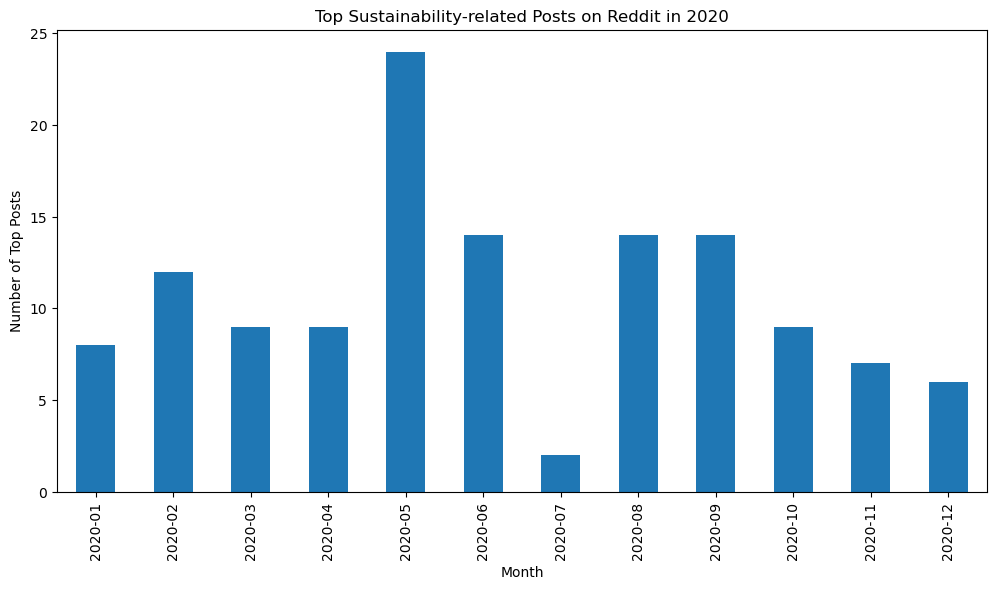

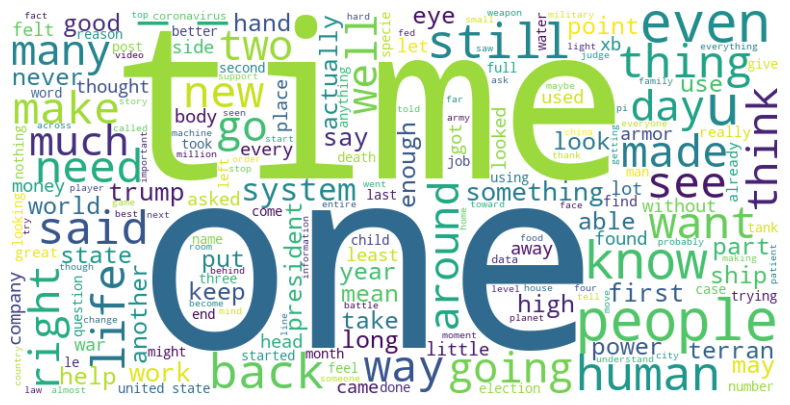

Top Authors in 2020:
author
Ralts_Bloodthorne      13
rusticgorilla           6
MikeBroihier            6
AskScienceModerator     3
_Joe_Momma_             3
CherubielOne            3
aguadovimeiro           3
Romanoff2020            2
Eric_Wulff              2
MansonsDaughter         2
Name: count, dtype: int64
subreddit
HFY                    19
IAmA                   10
nosleep                 7
Keep_Track              6
politics                6
wallstreetbets          4
loseit                  3
AmItheAsshole           3
UnresolvedMysteries     3
stocks                  3
Name: count, dtype: int64
count    927.000000
mean       0.421939
std        0.785086
min       -0.999900
25%        0.000000
50%        0.974200
75%        0.997800
max        1.000000
Name: Compound, dtype: float64


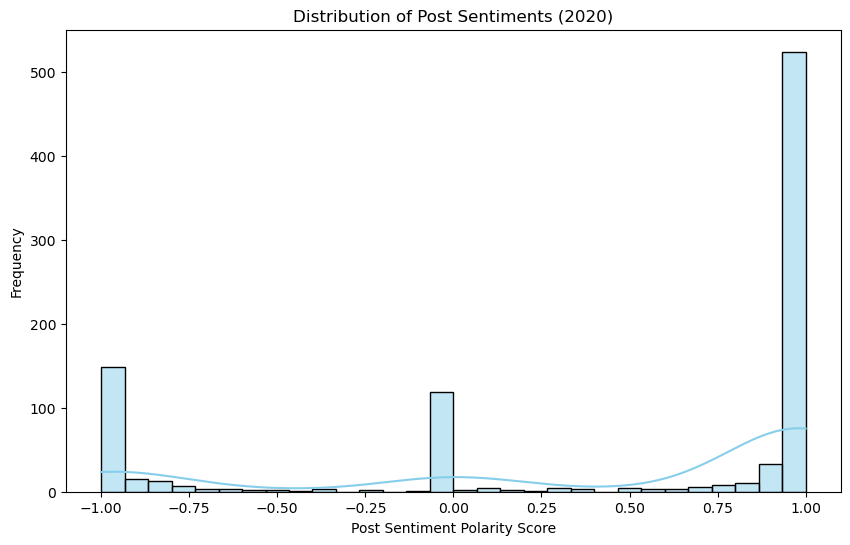

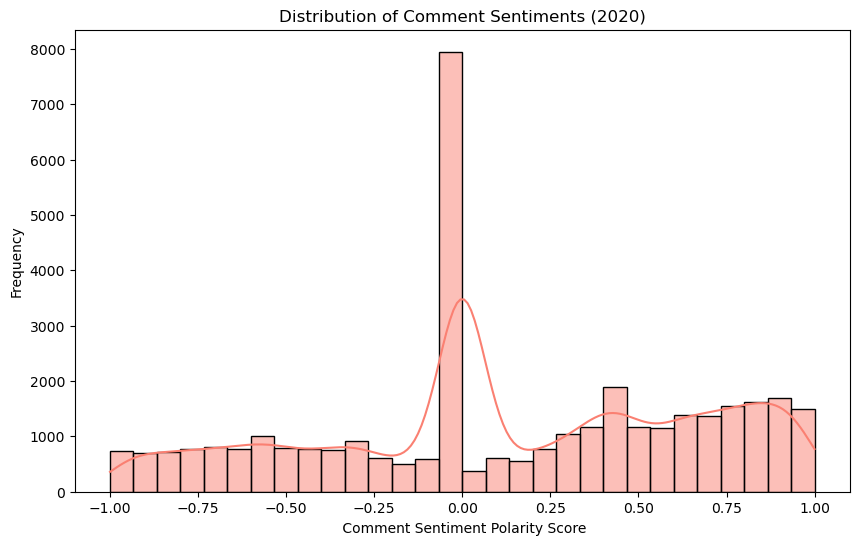

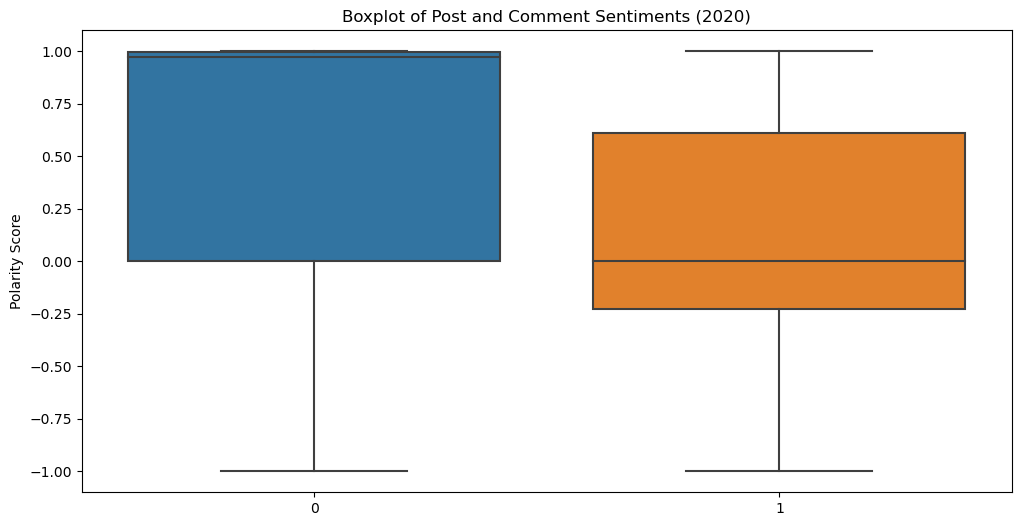

In [52]:
df_all['Cleaned Post Text'] = df_all['selftext'].apply(clean_post_text)
df_all['Sentiment Scores'] = df_all['Cleaned Post Text'].apply(analyze_sentiment)

# Extract compound score and classify the sentiment as positive, negative, or neutral
df_all['Compound'] = df_all['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_all['Sentiment'] = df_all['Compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))

# Analyze the data
df_all['month'] = df_all['created'].dt.to_period('M')

#Filter for 2019
df_2020 = df_all[(df_all['created'].dt.year == 2020)]
top_posts_per_month = df_2020.groupby('month').size()

# Plotting the number of top posts over time
top_posts_per_month.plot(kind='bar', figsize=(12, 6))
plt.title("Top Sustainability-related Posts on Reddit in 2020")
plt.xlabel("Month")
plt.ylabel("Number of Top Posts")
plt.show()

# Create the word cloud
# Concatenate the 'body' and 'text' columns into a single string
combined_text = ' '.join(df_2020['Cleaned Post Text'] + ' ' + df_2020['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()

# Group by author and count the number of posts per author
author_distribution = df_2020['author'].value_counts()

# Print the top authors
print("Top Authors in 2020:")
print(author_distribution.head(10))

sub_distribution = df_2020['subreddit'].value_counts()

print(sub_distribution.head(10))

print(df_all['Compound'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_all['Compound'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Sentiments (2020)')
plt.xlabel('Post Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_comments_2020['comment_sentiment'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Comment Sentiments (2020)')
plt.xlabel(' Comment Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=[df_all['Compound'], df_comments_2020['comment_sentiment']])
plt.title('Boxplot of Post and Comment Sentiments (2020)')
plt.ylabel('Polarity Score')
plt.show()


/var/folders/cv/8p3v6nnj09vgrlq0h88m03wh0000gn/T/ipykernel_4782/4293063956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['text_combined'] = df_2020['title'] + ' ' + df_2020['Cleaned Post Text']


Topic 0:
vale buy nickel tesla dr xb year marine covid kentucky
Topic 1:
like time know thing need human make people want good
Topic 2:
people time money war armor want say like president fed
Topic 3:
trump president state coronavirus court election pi people house year
Topic 4:
time like said military state know ship eye human little


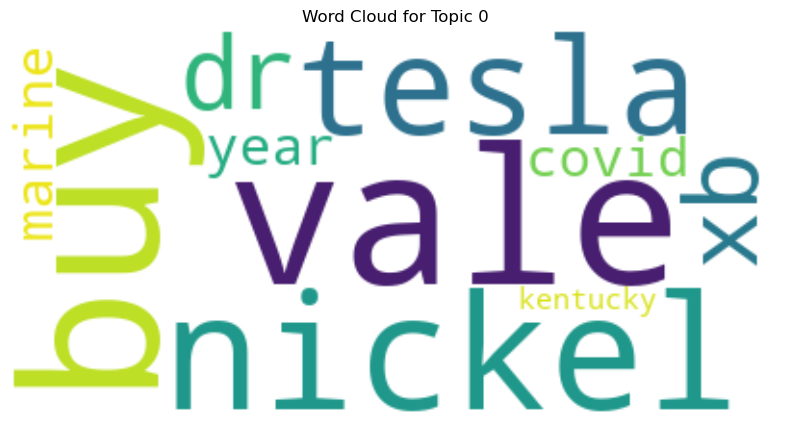

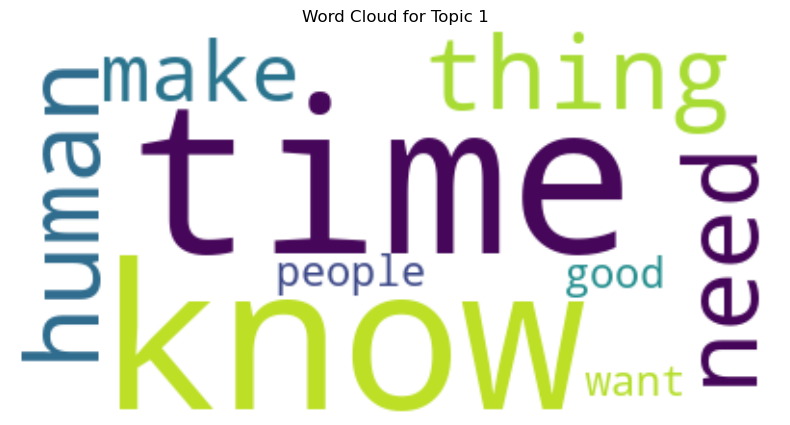

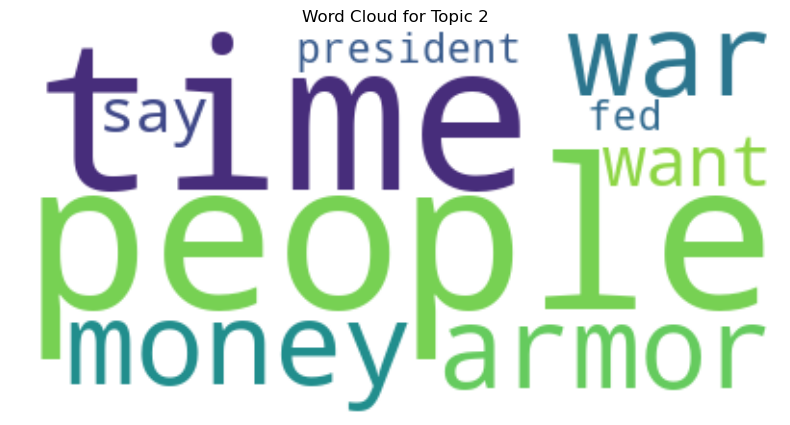

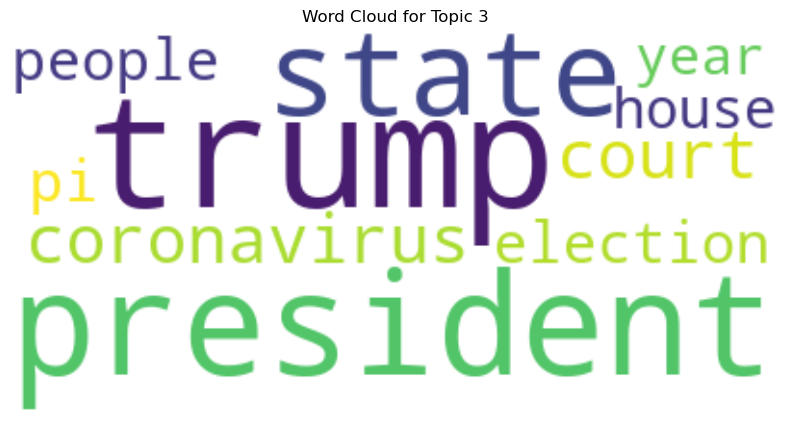

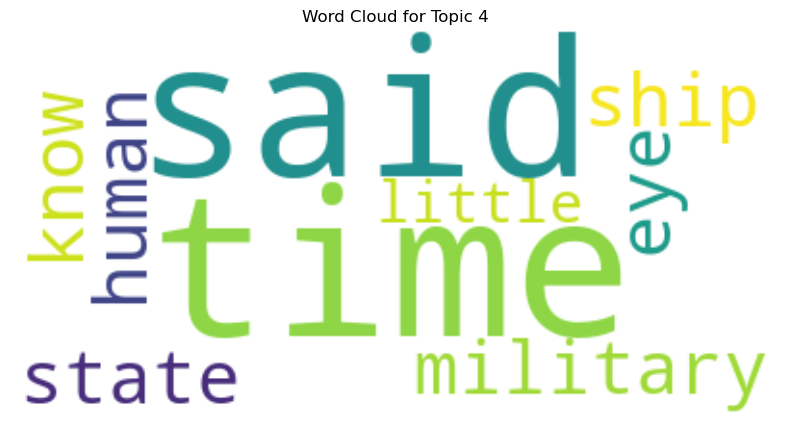

In [54]:

df_2020['text_combined'] = df_2020['title'] + ' ' + df_2020['Cleaned Post Text']

# Step 2: Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectorized = vectorizer.fit_transform(df_2020['text_combined'])

# Step 3: Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_vectorized)

# Step 4: Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Step 5: Create word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color='white').generate(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()


In [84]:

vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english', ngram_range=(1, 3))
text_vectorized = vectorizer.fit_transform(df_2020['text_combined'])

# Step 2: Applying LDA with Hyperparameter Tuning
lda = LatentDirichletAllocation(n_components=6, max_iter=30, random_state=42)
lda.fit(text_vectorized)

no_top_words = 6
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
head domain trump tweet using amid coronavirus trump claim
Topic 1:
cleveland blue economy injustice northeast mineral forming
Topic 2:
head domain trump tweet using amid coronavirus trump claim
Topic 3:
time people like trump said life
Topic 4:
communism socialism communist party nod tells
Topic 5:
kentucky marine mitch broihier mike mitch mcconnell


In [64]:
start_timestamp = datetime(2021, 1, 1).timestamp()  
end_timestamp = datetime(2021, 12, 31).timestamp() 

# Initialize lists to store posts and comments data
all_posts = []
comments_2021 = []

# Loop through each query and fetch posts
for query in queries:
    posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

    # Collect the posts, including author information and sentiment
    for submission in posts_best:
        post_date = datetime.fromtimestamp(submission.created_utc)
        
        # Append post data for the main table
        all_posts.append({
            'title': submission.title,
            'score': submission.score,
            'id': submission.id,
            'url': submission.url,
            'num_comments': submission.num_comments,
            'created': post_date,
            'subreddit': submission.subreddit.display_name,
            'author': str(submission.author),
            'selftext': submission.selftext
        })

       
        if start_timestamp <= submission.created_utc <= end_timestamp:
            # Analyze sentiment of the post
            post_text = submission.title + " " + submission.selftext
            post_sentiment = sid.polarity_scores(post_text)['compound']
            
           
            submission.comments.replace_more(limit=0)  # Replace "MoreComments" objects
            for comment in submission.comments.list():
                comment_text = comment.body
                comment_sentiment = sid.polarity_scores(comment_text)['compound']
                comments_2021.append({
                    'post_id': submission.id,
                    'comment_id': comment.id,
                    'comment_text': comment_text,
                    'comment_author': str(comment.author),
                    'comment_sentiment': comment_sentiment,
                    'comment_created': datetime.fromtimestamp(comment.created_utc)
                })

# Convert posts to DataFrame
df_all = pd.DataFrame(all_posts)

df_comments_2021 = pd.DataFrame(comments_2021)

# Check if DataFrames are empty
if df_all.empty:
    print("No posts found.")
else:
    print(f"Total posts found: {len(df_all)}")

if df_comments_2021.empty:
    print("No comments from 2021 found.")
else:
    print(f"Total comments from 2021: {len(df_comments_2021)}")

KeyboardInterrupt: 

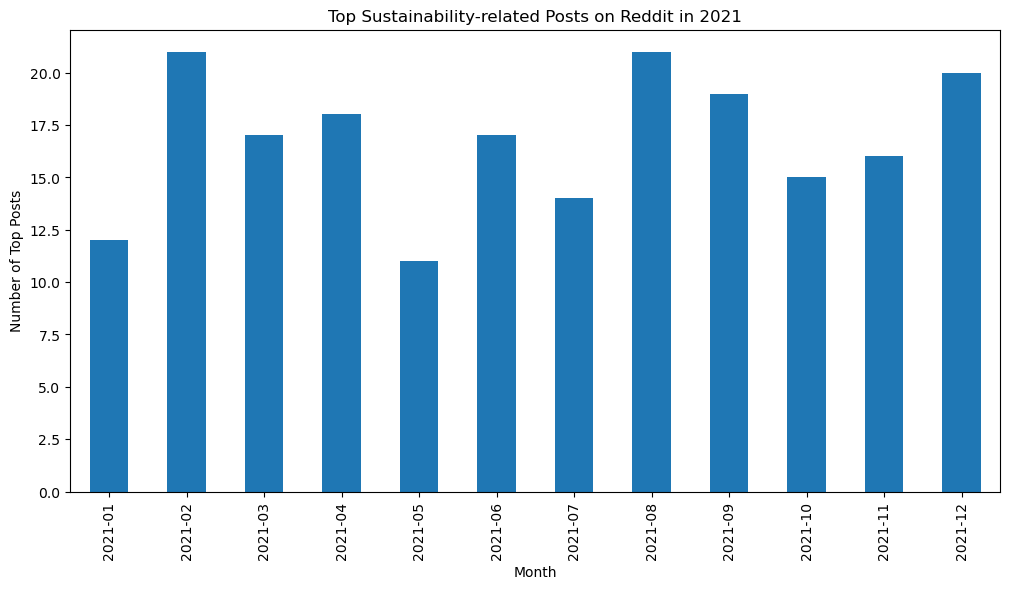

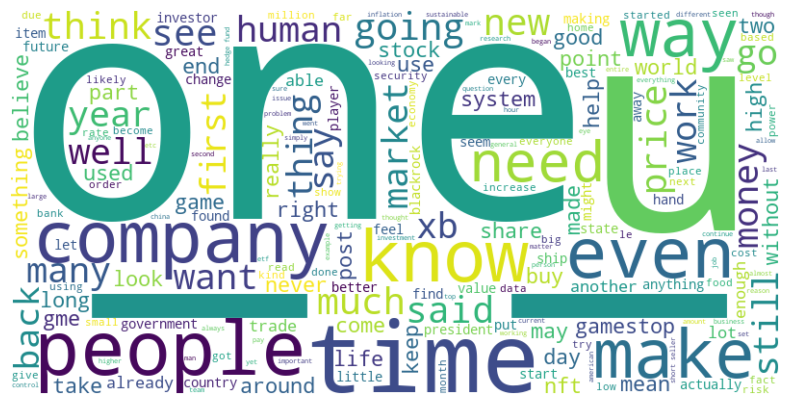

Top Authors in 2021:
author
SpacePaladin15         8
rusticgorilla          5
EsotericN1nja          4
Exceedingly            4
Ralts_Bloodthorne      4
bossblunts             3
ALDO113A               3
throwawaylurker012     3
Wild-Fisherman-2573    3
Bye_Triangle           2
Name: count, dtype: int64
subreddit
Superstonk          28
HFY                 22
CryptoMoonShots     20
wallstreetbets      11
CryptoCurrency       6
IAmA                 6
nosleep              5
investing            5
Keep_Track           5
unpopularopinion     4
Name: count, dtype: int64
count    927.000000
mean       0.421939
std        0.785086
min       -0.999900
25%        0.000000
50%        0.974200
75%        0.997800
max        1.000000
Name: Compound, dtype: float64


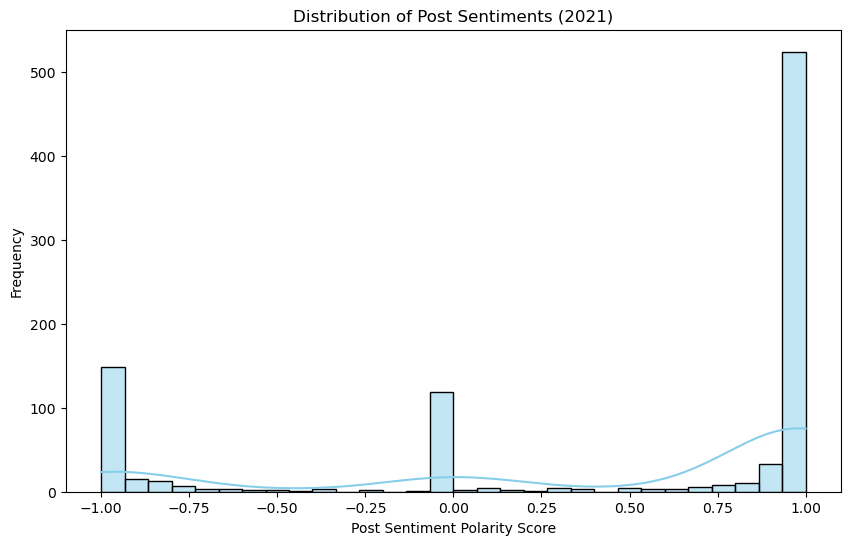

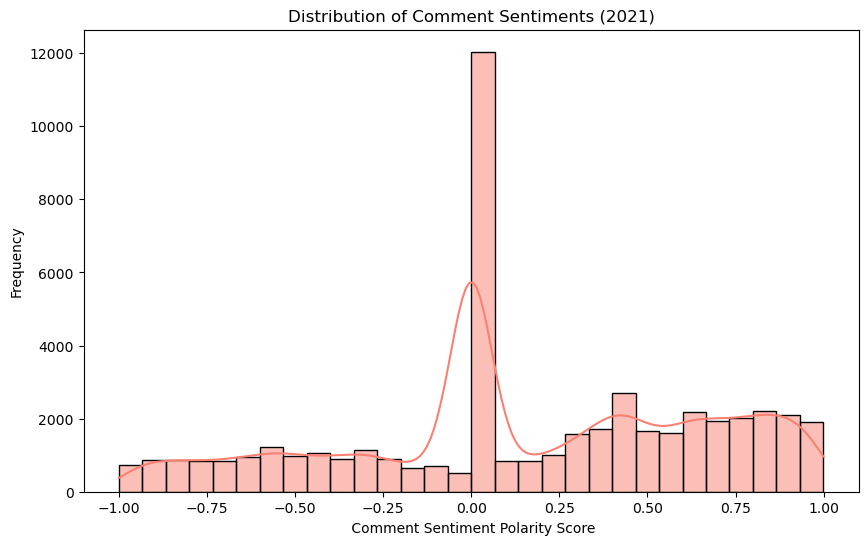

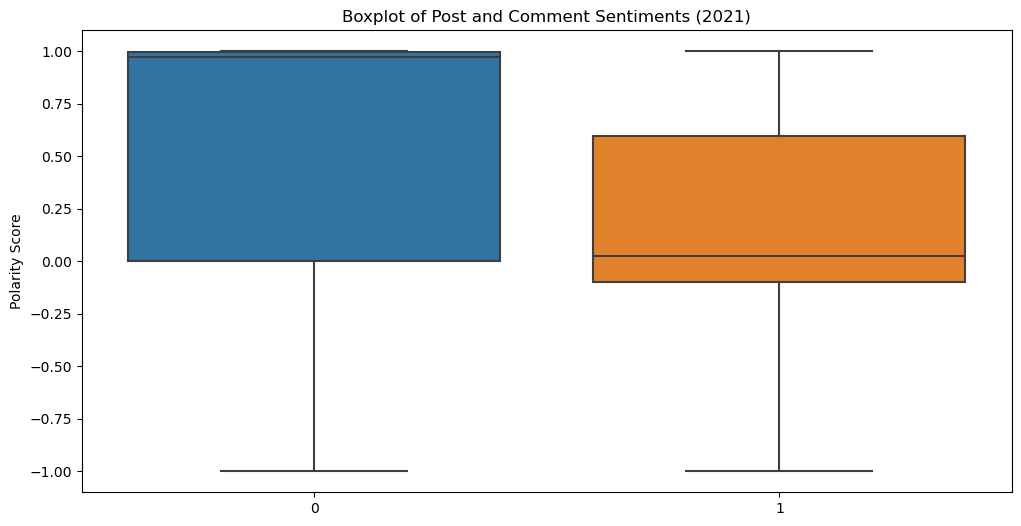

In [66]:
df_all['Cleaned Post Text'] = df_all['selftext'].apply(clean_post_text)
df_all['Sentiment Scores'] = df_all['Cleaned Post Text'].apply(analyze_sentiment)

# Extract compound score and classify the sentiment as positive, negative, or neutral
df_all['Compound'] = df_all['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_all['Sentiment'] = df_all['Compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))

# Analyze the data
df_all['month'] = df_all['created'].dt.to_period('M')

df_2021 = df_all[(df_all['created'].dt.year == 2021)]
top_posts_per_month = df_2021.groupby('month').size()

# Plotting the number of top posts over time
top_posts_per_month.plot(kind='bar', figsize=(12, 6))
plt.title("Top Sustainability-related Posts on Reddit in 2021")
plt.xlabel("Month")
plt.ylabel("Number of Top Posts")
plt.show()

# Create the word cloud
# Concatenate the 'body' and 'text' columns into a single string
combined_text = ' '.join(df_2021['Cleaned Post Text'] + ' ' + df_2021['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()

# Group by author and count the number of posts per author
author_distribution = df_2021['author'].value_counts()

# Print the top authors
print("Top Authors in 2021:")
print(author_distribution.head(10))

sub_distribution = df_2021['subreddit'].value_counts()

print(sub_distribution.head(10))

print(df_all['Compound'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_all['Compound'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Sentiments (2021)')
plt.xlabel('Post Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_comments_2021['comment_sentiment'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Comment Sentiments (2021)')
plt.xlabel(' Comment Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=[df_all['Compound'], df_comments_2021['comment_sentiment']])
plt.title('Boxplot of Post and Comment Sentiments (2021)')
plt.ylabel('Polarity Score')
plt.show()


/var/folders/cv/8p3v6nnj09vgrlq0h88m03wh0000gn/T/ipykernel_4782/2480982162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['text_combined'] = df_2021['title'] + ' ' + df_2021['Cleaned Post Text']


Topic 0:
short market share price stock
Topic 1:
like time said xb trump
Topic 2:
president mark war nft game
Topic 3:
company year market blackrock new
Topic 4:
human like life people time


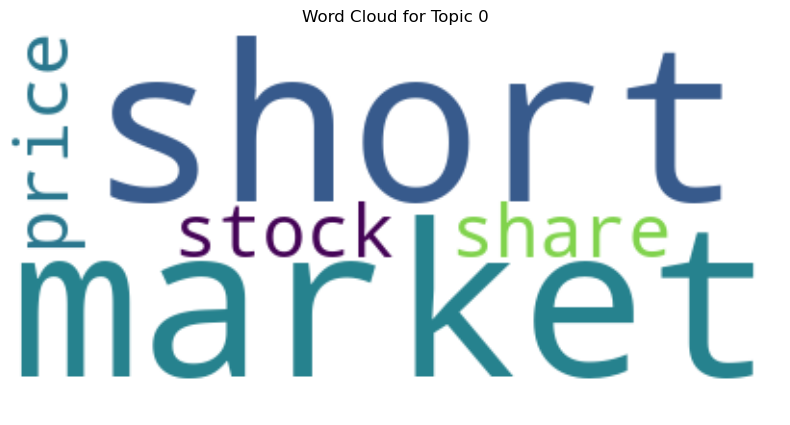

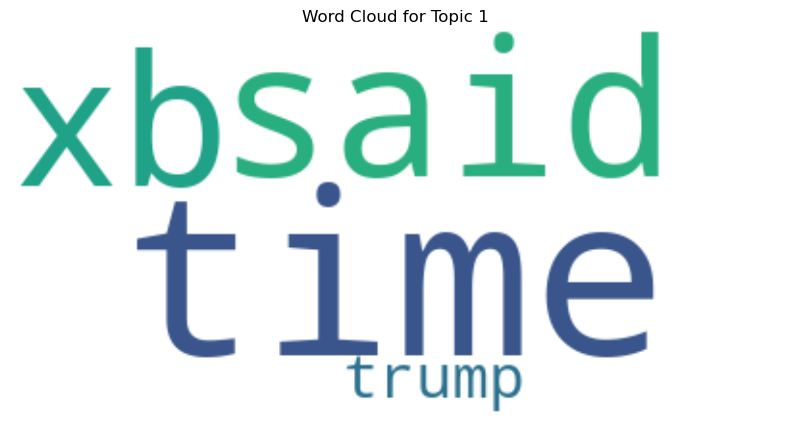

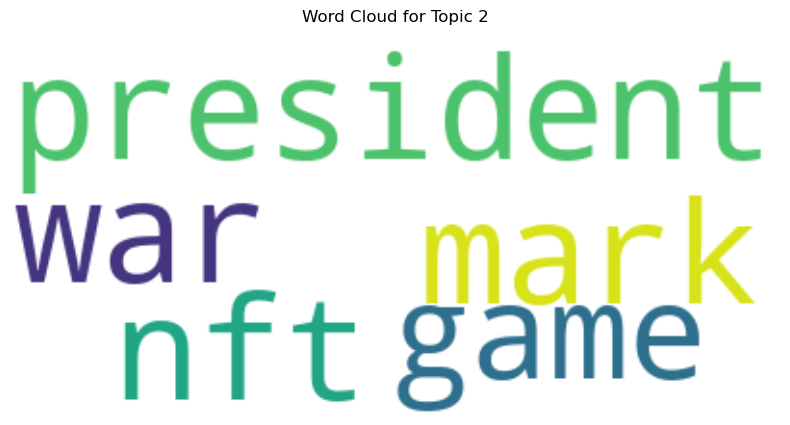

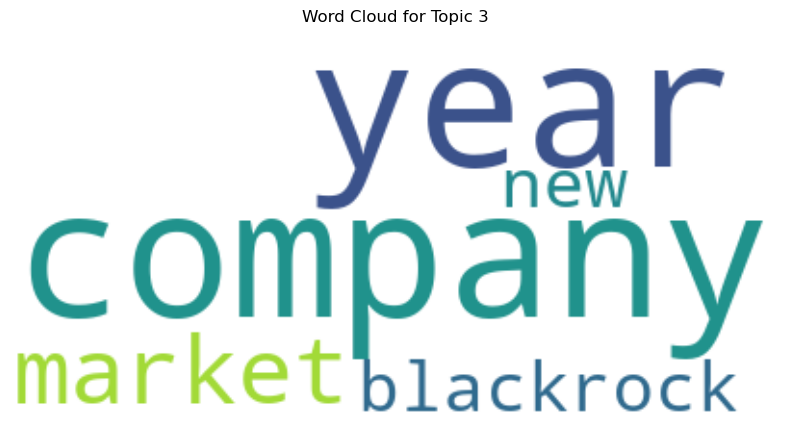

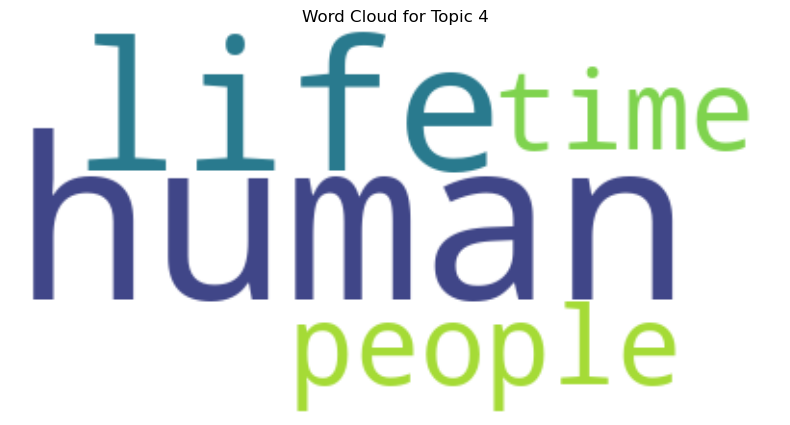

In [68]:
df_2021['text_combined'] = df_2021['title'] + ' ' + df_2021['Cleaned Post Text']

# Step 2: Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectorized = vectorizer.fit_transform(df_2021['text_combined'])

# Step 3: Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_vectorized)

# Step 4: Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Step 5: Create word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color='white').generate(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()


In [101]:

vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english', ngram_range=(1, 3))
text_vectorized = vectorizer.fit_transform(df_2021['title'])

# Step 2: Applying LDA with Hyperparameter Tuning
lda = LatentDirichletAllocation(n_components=6, max_iter=30, random_state=42)
lda.fit(text_vectorized)

no_top_words = 6
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
market reddit home time life gme
Topic 1:
game nft china crypto need play
Topic 2:
war humans avoid war humans avoid avoid war avoid cmv
Topic 3:
2021 like etfs update 10 soon
Topic 4:
dd biden trump token sustainable earth
Topic 5:
great contact chapter species 50 future


In [72]:
start_timestamp = datetime(2022, 1, 1).timestamp()  
end_timestamp = datetime(2022, 12, 31).timestamp() 

# Initialize lists to store posts and comments data
all_posts = []
comments_2022 = []

# Loop through each query and fetch posts
for query in queries:
    posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

    # Collect the posts, including author information and sentiment
    for submission in posts_best:
        post_date = datetime.fromtimestamp(submission.created_utc)
        
        # Append post data for the main table
        all_posts.append({
            'title': submission.title,
            'score': submission.score,
            'id': submission.id,
            'url': submission.url,
            'num_comments': submission.num_comments,
            'created': post_date,
            'subreddit': submission.subreddit.display_name,
            'author': str(submission.author),
            'selftext': submission.selftext
        })

       
        if start_timestamp <= submission.created_utc <= end_timestamp:
            # Analyze sentiment of the post
            post_text = submission.title + " " + submission.selftext
            post_sentiment = sid.polarity_scores(post_text)['compound']
            
           
            submission.comments.replace_more(limit=0)  # Replace "MoreComments" objects
            for comment in submission.comments.list():
                comment_text = comment.body
                comment_sentiment = sid.polarity_scores(comment_text)['compound']
                comments_2022.append({
                    'post_id': submission.id,
                    'comment_id': comment.id,
                    'comment_text': comment_text,
                    'comment_author': str(comment.author),
                    'comment_sentiment': comment_sentiment,
                    'comment_created': datetime.fromtimestamp(comment.created_utc)
                })

# Convert posts to DataFrame
df_all = pd.DataFrame(all_posts)

df_comments_2022 = pd.DataFrame(comments_2022)

# Check if DataFrames are empty
if df_all.empty:
    print("No posts found.")
else:
    print(f"Total posts found: {len(df_all)}")

if df_comments_2022.empty:
    print("No comments from 2022 found.")
else:
    print(f"Total comments from 2022: {len(df_comments_2022)}")

Total posts found: 927
Total comments from 2022: 35665


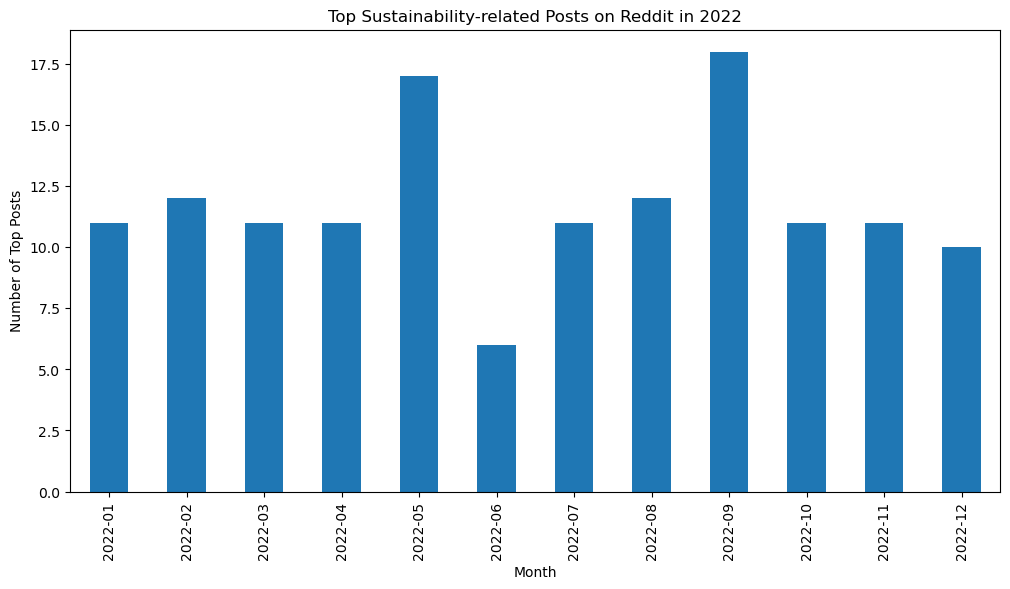

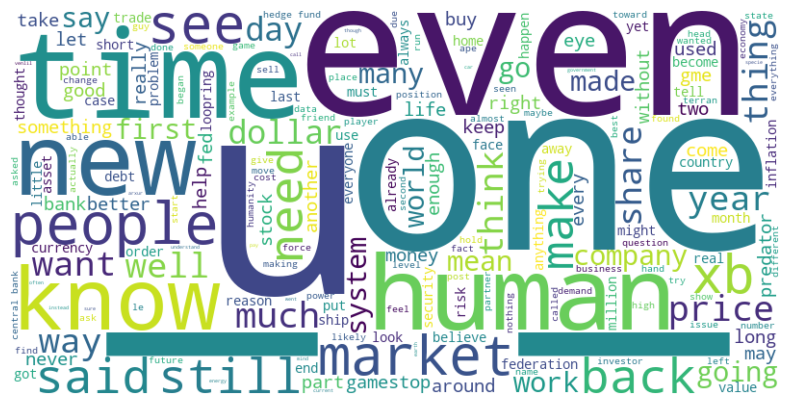

Top Authors in 2022:
author
SpacePaladin15    13
peruvian_bull      7
rusticgorilla      6
Jcb112             4
BENGCakez          3
riverstyxoath      2
AngryUrbanist      2
Rami54             2
Thump4             2
dilkmud0002        2
Name: count, dtype: int64
subreddit
Superstonk               35
HFY                      21
Keep_Track                6
nosleep                   6
CryptoMoonShots           5
AmItheAsshole             4
BestofRedditorUpdates     4
stocks                    3
wallstreetbets            3
science                   2
Name: count, dtype: int64
count    927.000000
mean       0.421939
std        0.785086
min       -0.999900
25%        0.000000
50%        0.974200
75%        0.997800
max        1.000000
Name: Compound, dtype: float64


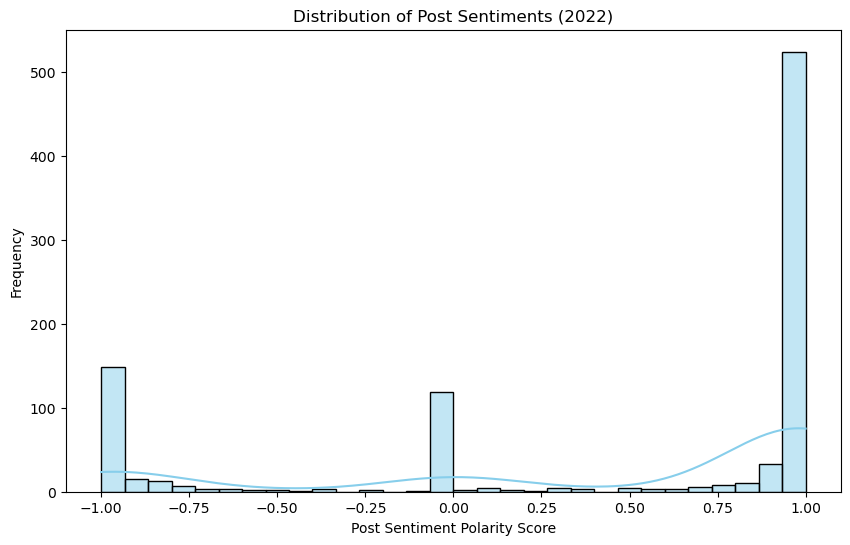

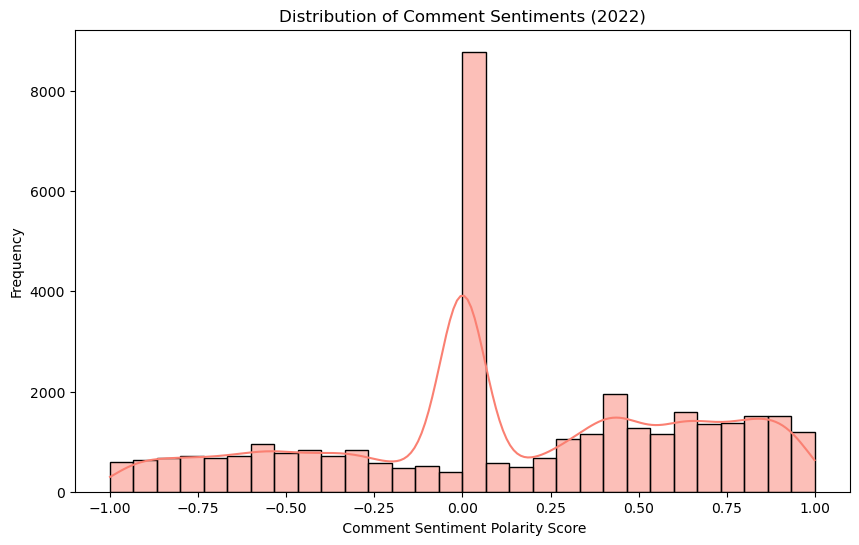

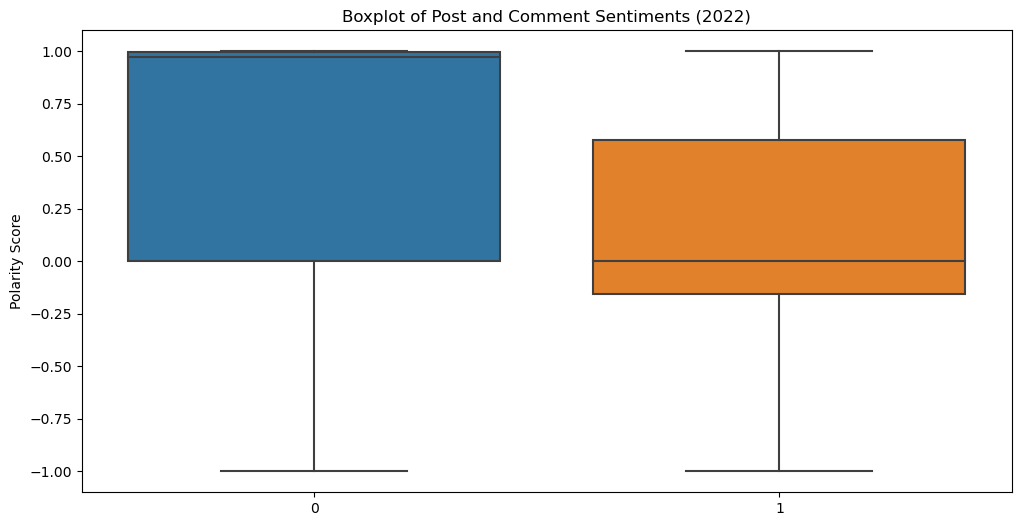

In [74]:
df_all['Cleaned Post Text'] = df_all['selftext'].apply(clean_post_text)
df_all['Sentiment Scores'] = df_all['Cleaned Post Text'].apply(analyze_sentiment)

# Extract compound score and classify the sentiment as positive, negative, or neutral
df_all['Compound'] = df_all['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_all['Sentiment'] = df_all['Compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))

# Analyze the data
df_all['month'] = df_all['created'].dt.to_period('M')

df_2022 = df_all[(df_all['created'].dt.year == 2022)]
top_posts_per_month = df_2022.groupby('month').size()

# Plotting the number of top posts over time
top_posts_per_month.plot(kind='bar', figsize=(12, 6))
plt.title("Top Sustainability-related Posts on Reddit in 2022")
plt.xlabel("Month")
plt.ylabel("Number of Top Posts")
plt.show()

# Create the word cloud
# Concatenate the 'body' and 'text' columns into a single string
combined_text = ' '.join(df_2022['Cleaned Post Text'] + ' ' + df_2022['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()

# Group by author and count the number of posts per author
author_distribution = df_2022['author'].value_counts()

# Print the top authors
print("Top Authors in 2022:")
print(author_distribution.head(10))

sub_distribution = df_2022['subreddit'].value_counts()

print(sub_distribution.head(10))

print(df_all['Compound'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_all['Compound'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Sentiments (2022)')
plt.xlabel('Post Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_comments_2022['comment_sentiment'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Comment Sentiments (2022)')
plt.xlabel(' Comment Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=[df_all['Compound'], df_comments_2022['comment_sentiment']])
plt.title('Boxplot of Post and Comment Sentiments (2022)')
plt.ylabel('Polarity Score')
plt.show()


/var/folders/cv/8p3v6nnj09vgrlq0h88m03wh0000gn/T/ipykernel_4782/3225029835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['text_combined'] = df_2022['title'] + ' ' + df_2022['Cleaned Post Text']


Topic 0:
human time overstock predator ship com federation like eye terran
Topic 1:
gamestop market game volume minute marketplace digital water sale used
Topic 2:
market dollar xb price bank share short stock financial fed
Topic 3:
player car people game loopring community company new year state
Topic 4:
like time know day thing said think esg want make


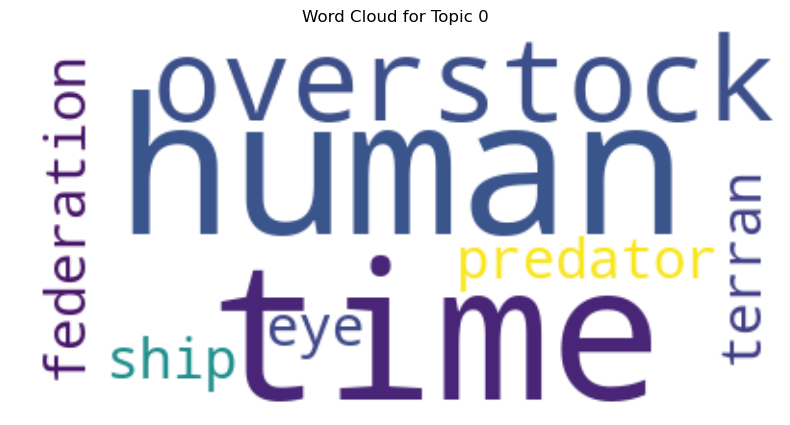

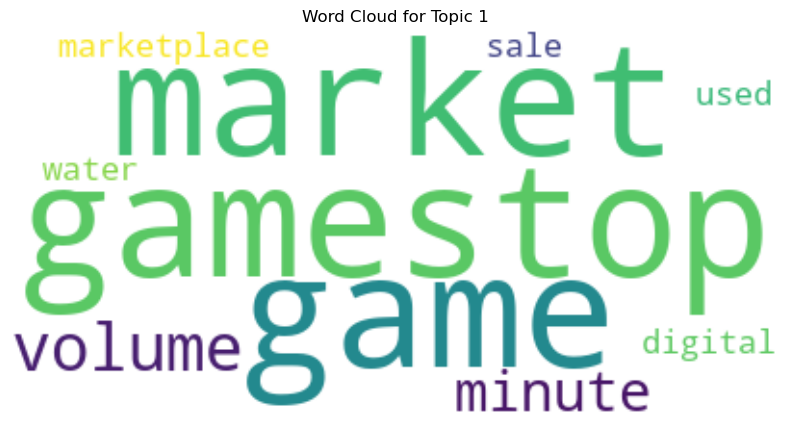

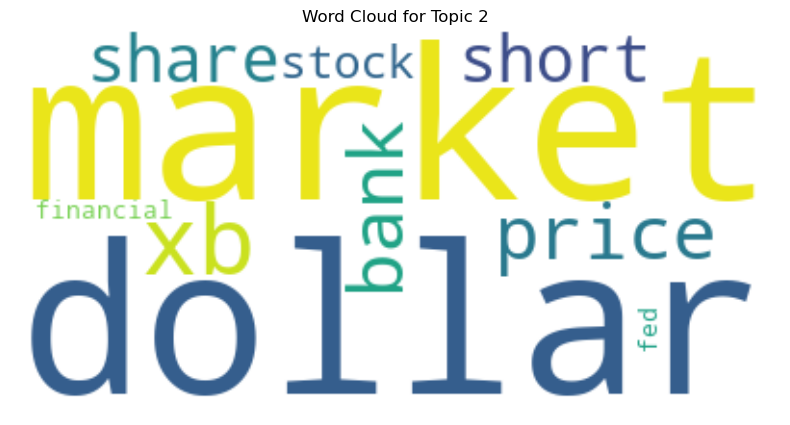

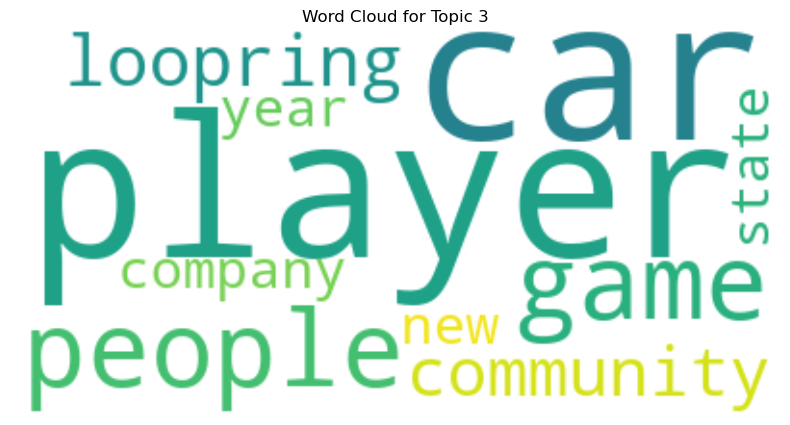

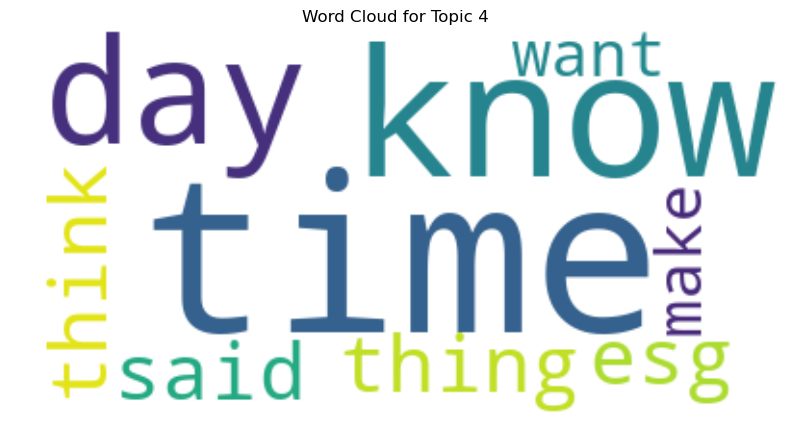

In [76]:
df_2022['text_combined'] = df_2022['title'] + ' ' + df_2022['Cleaned Post Text']

# Step 2: Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectorized = vectorizer.fit_transform(df_2022['text_combined'])

# Step 3: Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_vectorized)

# Step 4: Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Step 5: Create word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color='white').generate(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()


In [151]:

vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english', ngram_range=(1, 3))
text_vectorized = vectorizer.fit_transform(df_2022['title'])

# Step 2: Applying LDA with Hyperparameter Tuning
lda = LatentDirichletAllocation(n_components=6, max_iter=30, random_state=42)
lda.fit(text_vectorized)

no_top_words = 6
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
aita fed right new inflation hedge
Topic 1:
nature predators nature predators like read overstock
Topic 2:
coming dollar world dollar endgame endgame break
Topic 3:
german government work market company gamestop
Topic 4:
just years minimum according carbon market
Topic 5:
humans time environmental know year real


In [109]:
start_timestamp = datetime(2023, 1, 1).timestamp()  
end_timestamp = datetime(2023, 12, 31).timestamp() 

# Initialize lists to store posts and comments data
all_posts = []
comments_2023 = []

# Loop through each query and fetch posts
for query in queries:
    posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

    # Collect the posts, including author information and sentiment
    for submission in posts_best:
        post_date = datetime.fromtimestamp(submission.created_utc)
        
        # Append post data for the main table
        all_posts.append({
            'title': submission.title,
            'score': submission.score,
            'id': submission.id,
            'url': submission.url,
            'num_comments': submission.num_comments,
            'created': post_date,
            'subreddit': submission.subreddit.display_name,
            'author': str(submission.author),
            'selftext': submission.selftext
        })

       
        if start_timestamp <= submission.created_utc <= end_timestamp:
            # Analyze sentiment of the post
            post_text = submission.title + " " + submission.selftext
            post_sentiment = sid.polarity_scores(post_text)['compound']
            
           
            submission.comments.replace_more(limit=0)  # Replace "MoreComments" objects
            for comment in submission.comments.list():
                comment_text = comment.body
                comment_sentiment = sid.polarity_scores(comment_text)['compound']
                
                # Append comment data to the 2019 comments table
                comments_2023.append({
                    'post_id': submission.id,
                    'comment_id': comment.id,
                    'comment_text': comment_text,
                    'comment_author': str(comment.author),
                    'comment_sentiment': comment_sentiment,
                    'comment_created': datetime.fromtimestamp(comment.created_utc)
                })

# Convert posts to DataFrame
df_all = pd.DataFrame(all_posts)

# Convert comments from 2019 to DataFrame
df_comments_2023 = pd.DataFrame(comments_2023)

# Check if DataFrames are empty
if df_all.empty:
    print("No posts found.")
else:
    print(f"Total posts found: {len(df_all)}")

if df_comments_2023.empty:
    print("No comments from 2023 found.")
else:
    print(f"Total comments from 2023: {len(df_comments_2023)}")

Total posts found: 927
Total comments from 2023: 38040


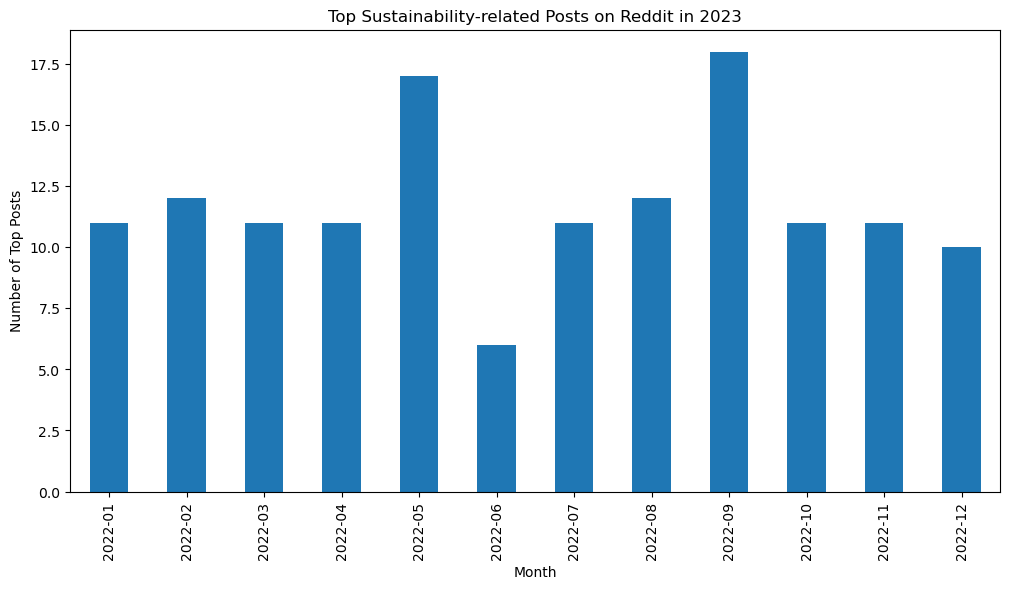

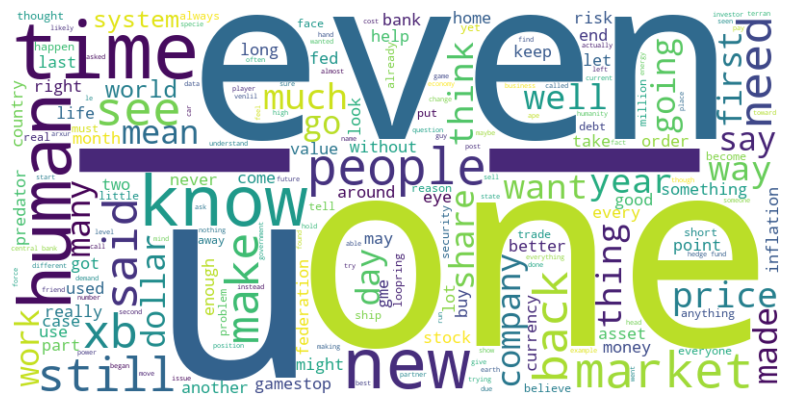

Top Authors in 2023:
author
SpacePaladin15    13
peruvian_bull      7
rusticgorilla      6
Jcb112             4
BENGCakez          3
riverstyxoath      2
AngryUrbanist      2
Rami54             2
Thump4             2
dilkmud0002        2
Name: count, dtype: int64
subreddit
Superstonk               35
HFY                      21
Keep_Track                6
nosleep                   6
CryptoMoonShots           5
AmItheAsshole             4
BestofRedditorUpdates     4
stocks                    3
wallstreetbets            3
science                   2
Name: count, dtype: int64
count    927.000000
mean       0.421939
std        0.785086
min       -0.999900
25%        0.000000
50%        0.974200
75%        0.997800
max        1.000000
Name: Compound, dtype: float64


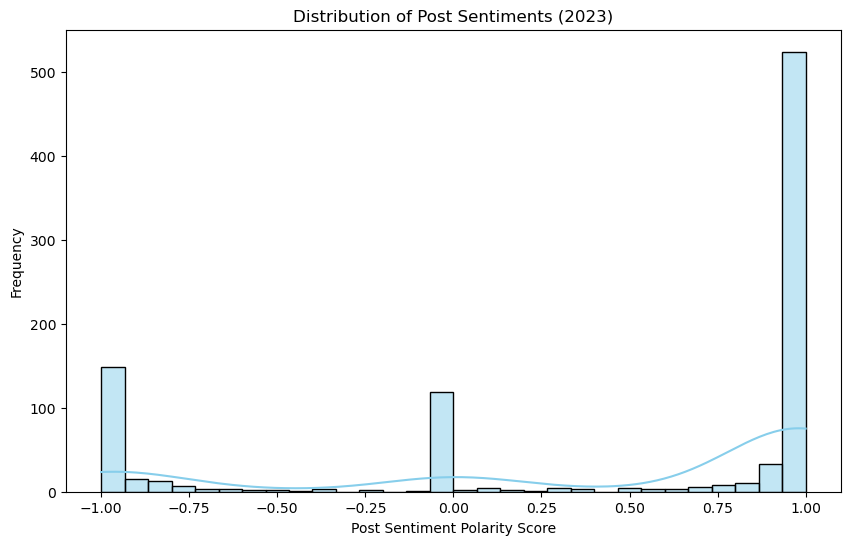

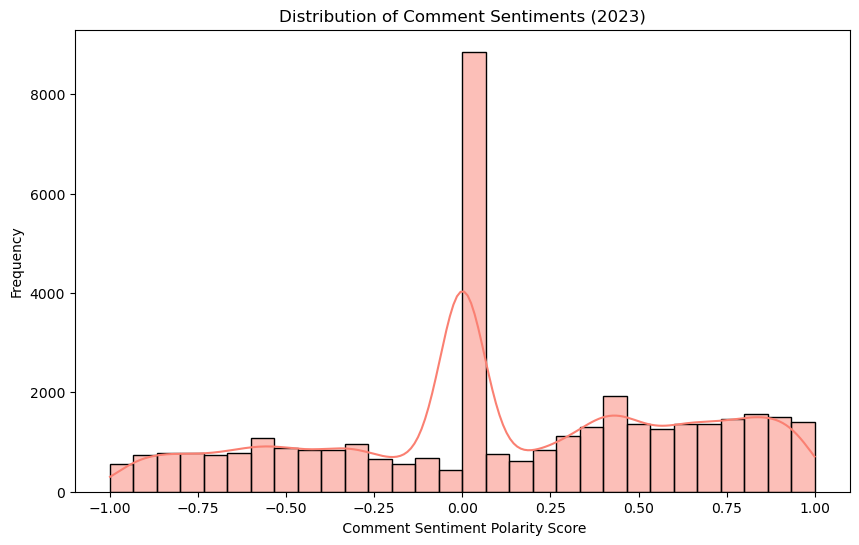

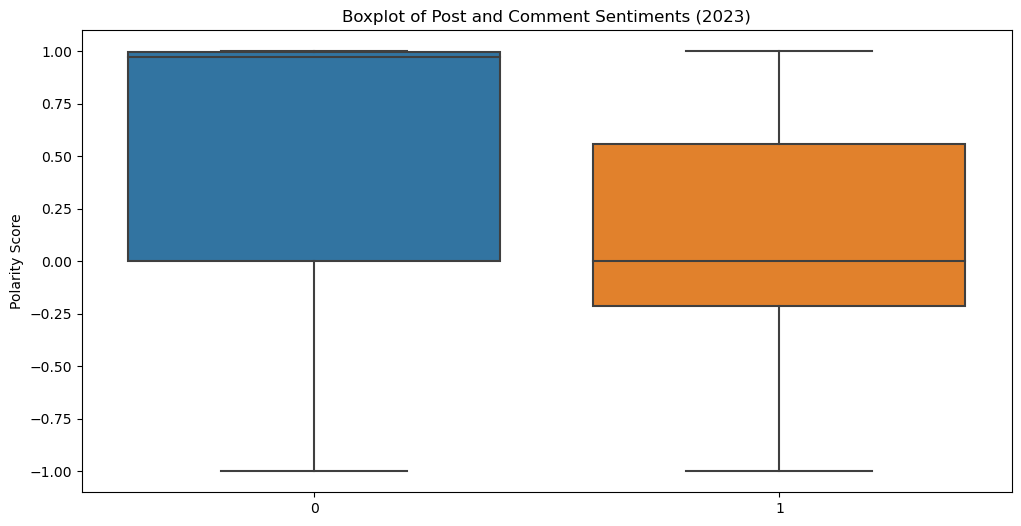

In [89]:
df_all['Cleaned Post Text'] = df_all['selftext'].apply(clean_post_text)
df_all['Sentiment Scores'] = df_all['Cleaned Post Text'].apply(analyze_sentiment)

# Extract compound score and classify the sentiment as positive, negative, or neutral
df_all['Compound'] = df_all['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_all['Sentiment'] = df_all['Compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))

# Analyze the data
df_all['month'] = df_all['created'].dt.to_period('M')

df_2023 = df_all[(df_all['created'].dt.year == 2022)]
top_posts_per_month = df_2023.groupby('month').size()

# Plotting the number of top posts over time
top_posts_per_month.plot(kind='bar', figsize=(12, 6))
plt.title("Top Sustainability-related Posts on Reddit in 2023")
plt.xlabel("Month")
plt.ylabel("Number of Top Posts")
plt.show()

# Create the word cloud
# Concatenate the 'body' and 'text' columns into a single string
combined_text = ' '.join(df_2023['Cleaned Post Text'] + ' ' + df_2023['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()

# Group by author and count the number of posts per author
author_distribution = df_2023['author'].value_counts()

# Print the top authors
print("Top Authors in 2023:")
print(author_distribution.head(10))

sub_distribution = df_2023['subreddit'].value_counts()

print(sub_distribution.head(10))

print(df_all['Compound'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_all['Compound'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Sentiments (2023)')
plt.xlabel('Post Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_comments_2023['comment_sentiment'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Comment Sentiments (2023)')
plt.xlabel(' Comment Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=[df_all['Compound'], df_comments_2023['comment_sentiment']])
plt.title('Boxplot of Post and Comment Sentiments (2023)')
plt.ylabel('Polarity Score')
plt.show()


/var/folders/cv/8p3v6nnj09vgrlq0h88m03wh0000gn/T/ipykernel_4782/3889826123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['text_combined'] = df_2023['title'] + ' ' + df_2023['Cleaned Post Text']


Topic 0:
human time overstock predator ship com federation like eye terran
Topic 1:
gamestop market game volume minute marketplace digital water sale used
Topic 2:
market dollar xb price bank share short stock financial fed
Topic 3:
player car people game loopring community company new year state
Topic 4:
like time know day thing said think esg want make


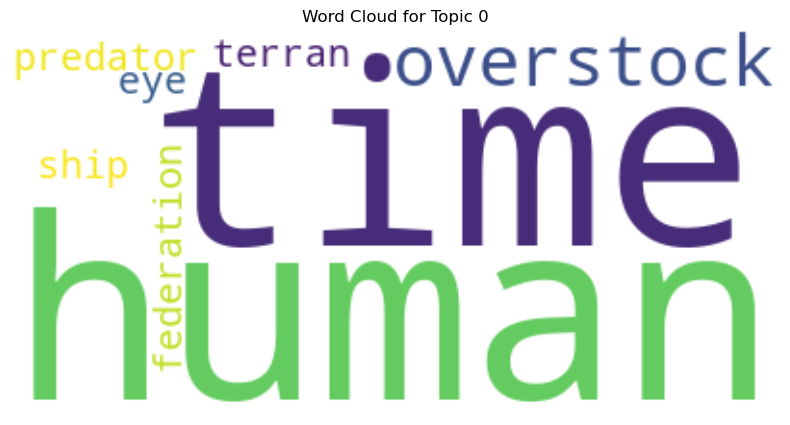

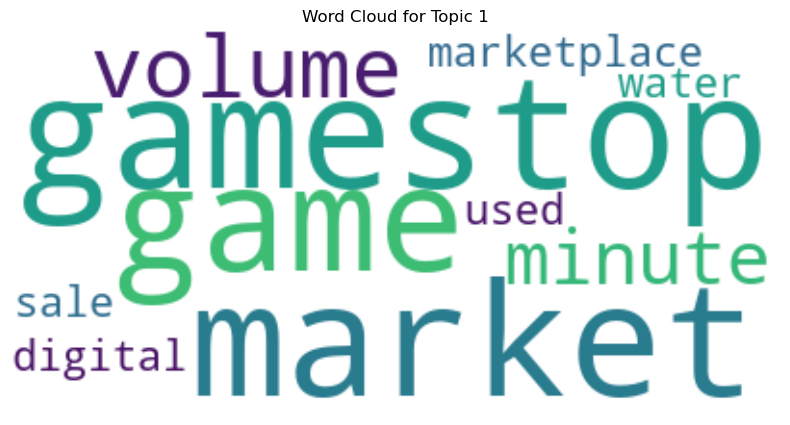

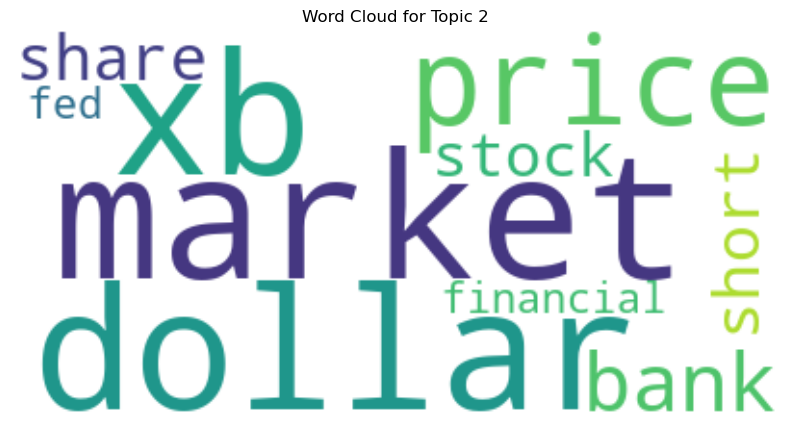

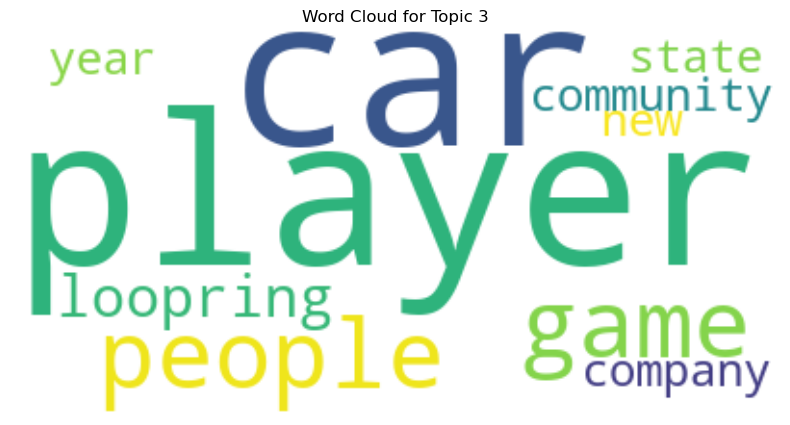

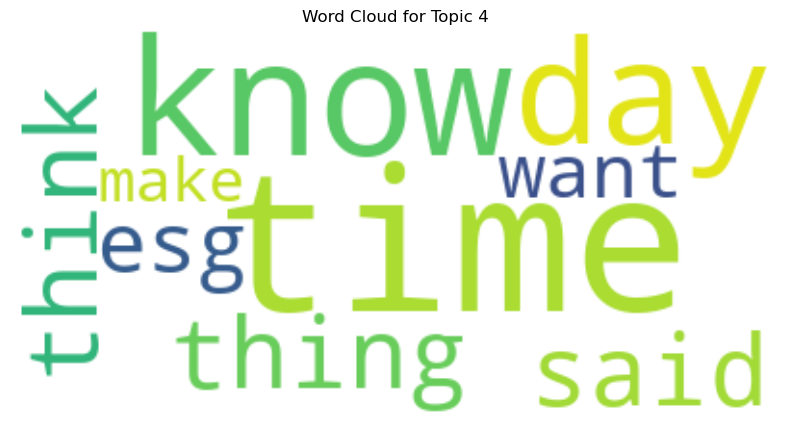

In [90]:
df_2023['text_combined'] = df_2023['title'] + ' ' + df_2023['Cleaned Post Text']

# Step 2: Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectorized = vectorizer.fit_transform(df_2023['text_combined'])

# Step 3: Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_vectorized)

# Step 4: Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Step 5: Create word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color='white').generate(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()


In [91]:

vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english', ngram_range=(1, 3))
text_vectorized = vectorizer.fit_transform(df_2023['text_combined'])

# Step 2: Applying LDA with Hyperparameter Tuning
lda = LatentDirichletAllocation(n_components=6, max_iter=30, random_state=42)
lda.fit(text_vectorized)

no_top_words = 6
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
troubled ensuring committed forgotten german germany
Topic 1:
overstock overstock com com la immediate defendant
Topic 2:
asks disability moment real time milk
Topic 3:
like market human time year price
Topic 4:
sustainable wsj going la moment milk
Topic 5:
ficc gov blackrock alert dtc nscc


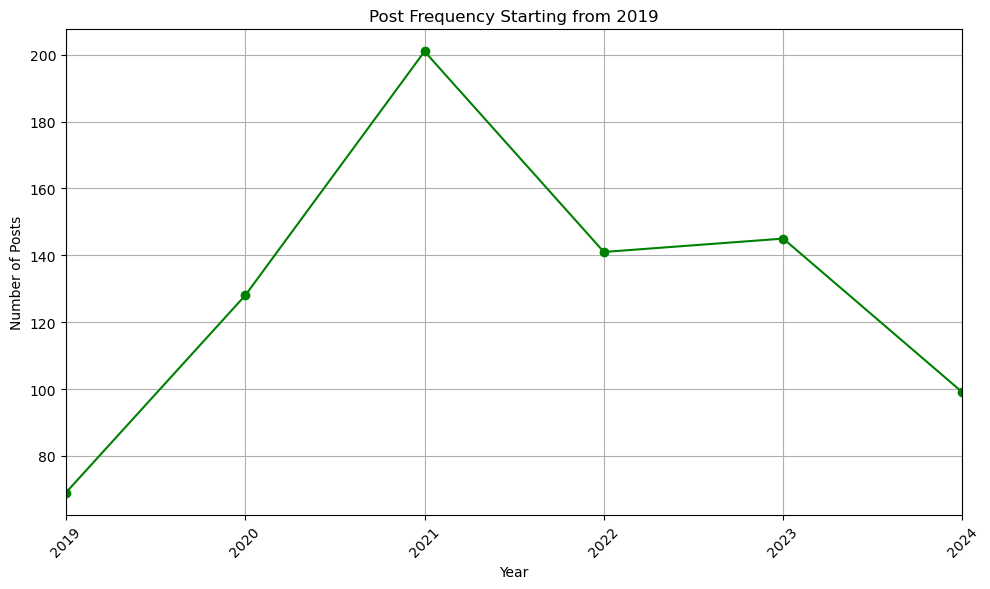

In [205]:
df_all['created'] = pd.to_datetime(df_all['created'])

df_from_2019 = df_all[df_all['created'].dt.year >= 2019]

# Step 3: Group by year (or by month) and count the number of posts for each year
post_frequency_by_year = df_from_2019.groupby(df_from_2019['created'].dt.to_period('Y')).size()

# Step 4: Plot the post frequency for 2019 onwards
plt.figure(figsize=(10, 6))
post_frequency_by_year.plot(kind='line', marker='o', linestyle='-', color='green')  # Line plot with markers
plt.title('Post Frequency Starting from 2019')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

float64


/var/folders/cv/8p3v6nnj09vgrlq0h88m03wh0000gn/T/ipykernel_4782/2505447965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_from_2019['Compound'] = pd.to_numeric(df_from_2019['Compound'], errors='coerce')


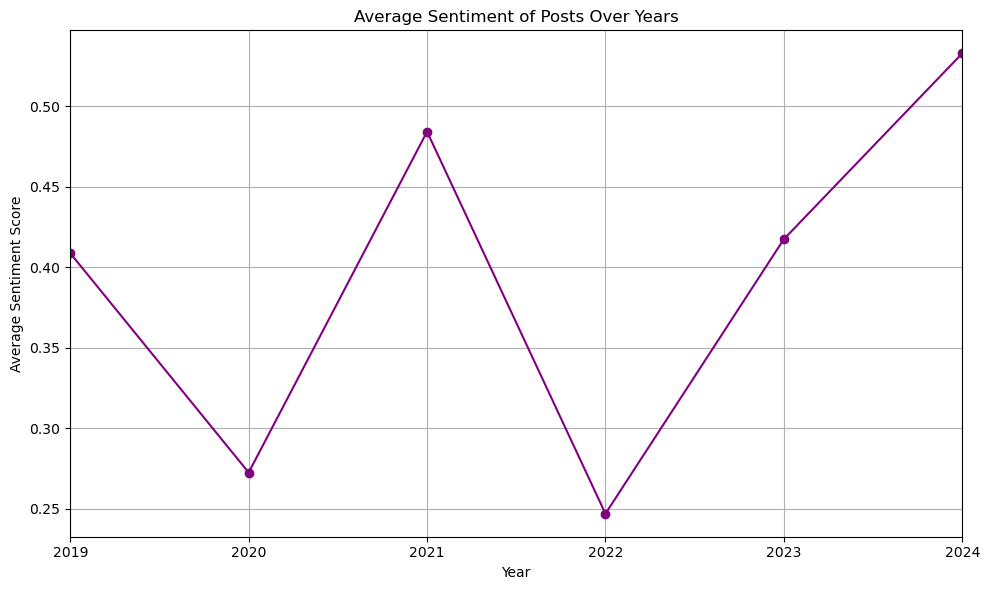

In [149]:
# Step 1: Convert 'created' column to datetime
df_all['created'] = pd.to_datetime(df_all['created'])

# Step 2: Filter posts from 2019 onwards
df_from_2019 = df_all[df_all['created'].dt.year >= 2019]

# Step 3: Ensure 'Compound' column contains only numeric values
# Convert 'Compound' column to numeric, coercing errors (non-numeric values) to NaN
df_from_2019['Compound'] = pd.to_numeric(df_from_2019['Compound'], errors='coerce')

# Step 4: Drop rows with NaN in 'Compound' (i.e., non-numeric data)
df_from_2019_clean = df_from_2019.dropna(subset=['Compound'])

# Step 5: Verify that 'Compound' is now purely numeric
print(df_from_2019_clean['Compound'].dtype)  # Should show 'float64' or 'int64'

# Step 6: Group by year and calculate the mean sentiment
average_sentiment_by_year = df_from_2019_clean.groupby(df_from_2019_clean['created'].dt.to_period('Y'))['Compound'].mean()

# Step 7: Plot the average sentiment over years
plt.figure(figsize=(10, 6))
average_sentiment_by_year.plot(kind='line', marker='o', linestyle='-', color='purple')
plt.title('Average Sentiment of Posts Over Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [97]:
df_all.to_csv('Tamporal.csv', index=False)

In [141]:
print(df_from_2019.columns)

Index(['title', 'score', 'id', 'url', 'num_comments', 'created', 'subreddit',
       'author', 'selftext', 'Cleaned Post Text', 'Sentiment Scores',
       'Compound', 'Sentiment', 'sentiment_score'],
      dtype='object')


In [133]:
print(df_all.columns)

Index(['title', 'score', 'id', 'url', 'num_comments', 'created', 'subreddit',
       'author', 'selftext', 'Cleaned Post Text', 'Sentiment Scores',
       'Compound', 'Sentiment'],
      dtype='object')


In [165]:
pd.set_option('display.max_colwidth', None)

# Now print the titles
df_all[df_all['author'] == 'rusticgorilla']['title']

60                                                                                            Trump under criminal investigation in Georgia
103                                           Unsafe drinking water in three majority Black areas: the legacy of systemic racism in America
116                          Biden admin appoints ICE lawyers and Trump appointees in first slate of immigration judges, angering advocates
129                                                 Biden administration approves of oil railway through National Forest｜Environmental news
142                          The Montana mine that produces 240 million tons of greenhouse gases, cocaine trafficking, and money laundering
184                                               Lost in the Sauce: Intel IG fired, White House lawyer nominated to oversee pandemic funds
337                                                        Biden's first week: Repealing Trump policies and struggling to confirm a cabinet
348                 

In [189]:
pd.set_option('display.max_colwidth', None)

# Now print the titles
df_all[df_all['subreddit'] == 'wallstreetbets']['title']

64                                                                                                                                                            Wanna Play $TSLA but no Money? $VALE
78                                                                                                                                                 Microvast ($MVST) -The only DD you'll ever need
94                                                                                                                                                       $GGPI Polestar - Global EV Pure Play - DD
234                                                                                                                                   WSJ fixed the headline, can you fix the rest of the article?
237                                                                                                                                                                       Reddit is saving America
254                      